In [1]:
from feature_extraction.fc import FetchROI
import os
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
import re
import random
from numpy.linalg import eigh,pinv
from statsmodels.tsa.api import VAR
import pickle

In [2]:
os.path.dirname(os.getcwd())

'/Users/admin/Documents'

In [5]:
roi_dir =  os.path.join(os.getcwd(),'rois_cc200')
pheno_path = os.path.join(os.getcwd(), 'phenotype_files','pheno_nn.csv')

In [6]:
pheno_df = pd.read_csv(pheno_path)

In [7]:
pheno_df.DX_GROUP.unique()[pheno_df.DX_GROUP.unique()==1].item()

1

In [8]:
roi_files = pheno_df.CC200
subjects = pheno_df.FILE_ID

In [13]:
fetch = FetchROI(roi_dir)

## Principal Component Analysis, Find Parameters

- PCA is required for large scale granger causality analysis

### Determine optimal component number to keep for lower dimensional space

In [14]:
t1 = fetch.fetch_roi_avg_ts(roi_files[0])

In [18]:
temporal_res = []
for file in roi_files:
    data = fetch.fetch_roi_avg_ts(file)
    l= len(data)
    temporal_res.append(l)

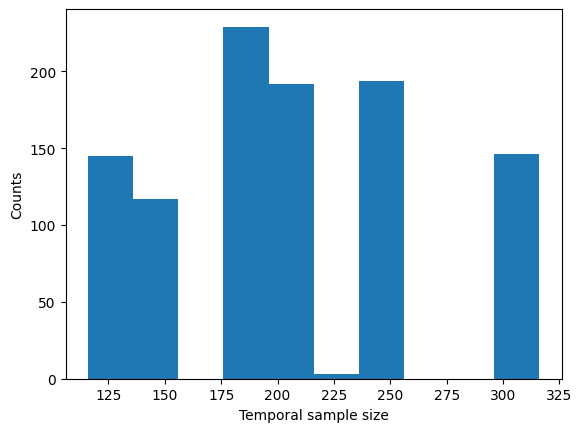

In [19]:
plt.Figure()
plt.hist(temporal_res)
plt.xlabel('Temporal sample size')
plt.ylabel('Counts')
plt.show()

- first 5 must be removed for magnetization stabilastion

In [20]:
min(temporal_res) # minimum sample size is 115 therefore the MVAR components must be compatiple with at least 115 temporal samples.

116

In [21]:
np.unique(np.array(temporal_res))

array([116, 124, 138, 146, 152, 176, 177, 196, 202, 206, 232, 234, 236,
       246, 296, 316])

In [22]:
min_files = []
for file in roi_files:
    data = fetch.fetch_roi_avg_ts(file)
    l= len(data)
    if l == 116:
        min_files.append(file)

In [77]:
all_var = []
for mf in min_files:
    test_data = fetch.fetch_roi_avg_ts(mf) # get time series data from random sample
    test_data = test_data[5:] # remove first five temporal samples
    X = test_data.to_numpy(dtype=np.float32)  # extract as numpy array of dtype float32 to halve memory usage
    Xn = normalize(X)  # normalise values for PCA
    model = PCA()  # instantiate pca model instant
    model.fit(Xn)  # carry out PCA and keep all components in order to understand variance ratio
    variance_ratio = model.explained_variance_ratio_
    cum_var = np.cumsum(variance_ratio)
    all_var.append(cum_var)

In [83]:
avg_var = np.mean(np.array(all_var), axis=0)

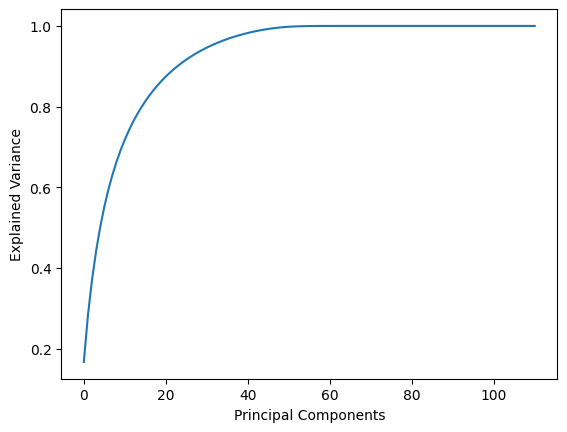

In [85]:
plt.figure()
plt.plot(avg_var) # plot cumulative variance ratio over number of principal components
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance")
plt.show()

Plot showing the fraction of variance explained with increasing number of principal components c for the empirical fMRI data. We obsereve that the lower end of the knee is approximately within 10 < c < 35. This range is useful to narrow down on an optimal order and c by minimizing the BIC.

In [90]:
roi_files

0           Pitt_0050002_rois_cc200.1D
1           Pitt_0050003_rois_cc200.1D
2           Pitt_0050004_rois_cc200.1D
3           Pitt_0050005_rois_cc200.1D
4           Pitt_0050006_rois_cc200.1D
                     ...              
1021         SBL_0051583_rois_cc200.1D
1022         SBL_0051584_rois_cc200.1D
1023         SBL_0051585_rois_cc200.1D
1024    MaxMun_a_0051606_rois_cc200.1D
1025    MaxMun_a_0051607_rois_cc200.1D
Name: CC200, Length: 1026, dtype: object

In [93]:
all_var = []
for mf in roi_files:
    test_data = fetch.fetch_roi_avg_ts(mf) # get time series data from random sample
    test_data = test_data[5:] # remove first five temporal samples
    X = test_data.to_numpy(dtype=np.float32)  # extract as numpy array of dtype float32 to halve memory usage
    Xn = normalize(X)  # normalise values for PCA
    model = PCA(n_components=100)  # instantiate pca model instant
    model.fit(Xn)  # carry out PCA and keep all components in order to understand variance ratio
    variance_ratio = model.explained_variance_ratio_
    cum_var = np.cumsum(variance_ratio)
    all_var.append(cum_var)

In [95]:
avg_var = np.mean(np.array(all_var), axis=0)

In [97]:
avg_var

array([0.16098006, 0.27290112, 0.35892427, 0.42859015, 0.48607025,
       0.53458166, 0.5760213 , 0.61199254, 0.6435689 , 0.6714573 ,
       0.6962836 , 0.71860117, 0.73876834, 0.7570472 , 0.7736838 ,
       0.78891754, 0.8029166 , 0.81584746, 0.8277783 , 0.83883107,
       0.8490957 , 0.85865784, 0.86758775, 0.8759329 , 0.8837544 ,
       0.89108866, 0.89797765, 0.9044616 , 0.91054875, 0.91628057,
       0.9216911 , 0.9267972 , 0.93161505, 0.93616277, 0.94045126,
       0.94449586, 0.94831383, 0.9519173 , 0.9553122 , 0.9585114 ,
       0.9615235 , 0.9643591 , 0.9670231 , 0.9695191 , 0.97185713,
       0.9740355 , 0.9760618 , 0.9779457 , 0.9796946 , 0.9813113 ,
       0.98280907, 0.98418087, 0.9854449 , 0.9866044 , 0.9876632 ,
       0.9886314 , 0.98951656, 0.9903206 , 0.9910606 , 0.99174106,
       0.9923663 , 0.99294174, 0.99347115, 0.99396306, 0.9944162 ,
       0.9948418 , 0.99524146, 0.99561614, 0.9959663 , 0.99629384,
       0.9965985 , 0.9968818 , 0.99714774, 0.9973938 , 0.99762

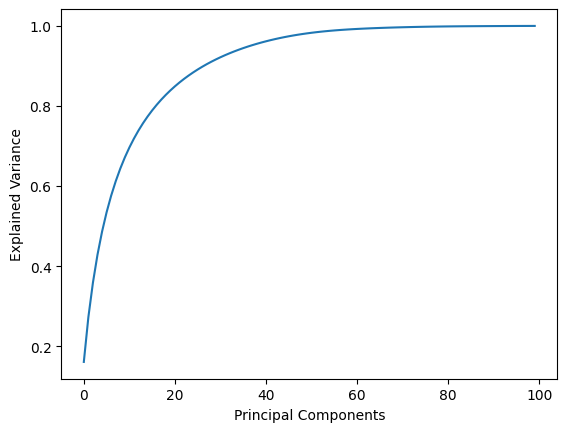

In [96]:
plt.figure()
plt.plot(avg_var) # plot cumulative variance ratio over number of principal components
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance")
plt.show()

## Determine optimal lag order p for the multi variate auto regression model

To find the best order p: We determine an optimal order for the MVAR model by minimizing the Bayesian Information Criterion over the range of c obtained above. The BIC can help narrow down the optimal c from the above range for the optimal order.

In [30]:
X_hat = model.fit_transform(Xn) #All transformed principal components

In [99]:
c_p_BIC = {} # store BIC values for each iteration of c and p
c_all = []
p_all = []
bic_all = []
for c in range(11,35):# for each value of c in range 10 >= c >= 25

    mvar = VAR(X_hat[:,:c])

    results = mvar.select_order(2) # Compute lag order selections based on each of the available information criteria, outputs Results class for choosing a model’s lag order.

    s = results.summary() # summary table as SimpleTable statsmodel object
    sd = s.data # extract summary data as list
    bics = [] # store BIC values for each lag
    for i,p in enumerate(sd[1:]): # from summary data first row is header, disregard and take each row, model order
        p_all.append(int(i))
        c_all.append(int(c))
        bic = p[2] # second element of list is the BIC value
        if re.search('\*',bic):# *is added if the value is the minium so search and remove
            bic = re.sub('\*', '' ,bic) # remove * from last BIC value
        bics.append(float(bic)) # convert BIC value from string to float and append to bics list
        bic_all.append(float(bic))
    c_p_BIC[c] = bics

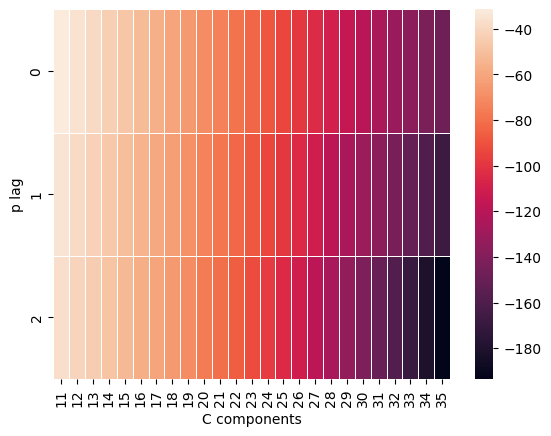

In [33]:
plt.Figure
sns.heatmap(pd.DataFrame(c_p_BIC), linewidth=0.5)
plt.ylabel('p lag')
plt.xlabel('C components')
plt.show()

based on heatmaps the lowest BIC is obtained when there are 35 principal components and a p lag parameter of 2 in the MVAR

## AAL atlas PCA components

In [1107]:
aal_dir = os.path.join(os.getcwd(),'rois_aal')

In [1108]:
subjects = pheno_df.FILE_ID
aal_files = [i + '_rois_aal.1D' for i in subjects]

In [1143]:
aal_fetch = FetchROI(aal_dir)

In [1144]:
temporal_res_aal = []
for file in aal_files:
    data = aal_fetch.fetch_roi_avg_ts(file)
    l= len(data)
    temporal_res_aal.append(l)

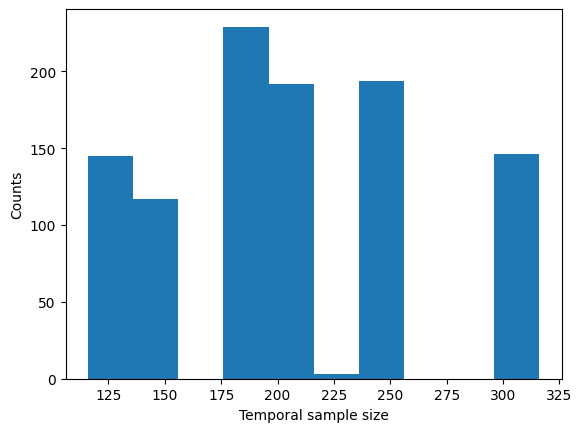

In [1145]:
plt.Figure()
plt.hist(temporal_res_aal)
plt.xlabel('Temporal sample size')
plt.ylabel('Counts')
plt.show()

- first 5 must be removed for magnetization stabilastion

In [1149]:
min(temporal_res_aal) # minimum sample size is 115 therefore the MVAR components must be compatiple with at least 115 temporal samples.

116

In [1153]:
np.unique(np.array(temporal_res_aal))

array([116, 124, 138, 146, 152, 176, 177, 196, 202, 206, 232, 234, 236,
       246, 296, 316])

In [1155]:
min_files = []
for file in aal_files:
    data = aal_fetch.fetch_roi_avg_ts(file)
    l= len(data)
    if l == 116:
        min_files.append(file)

In [1156]:
test_sample = random.choice(min_files) # find random subject to use for analysis

In [1159]:
test_data_aal = aal_fetch.fetch_roi_avg_ts(test_sample) # get time series data from random sample

In [1160]:
test_data_aal = test_data[5:] # remove first five temporal samples

In [1161]:
X_aal = test_data_aal.to_numpy(dtype=np.float32)  # extract as numpy array of dtype float32 to halve memory usage
XnA = normalize(X)  # normalise values for PCA

In [1162]:
modelA = PCA()  # instantiate pca model instant
modelA.fit(XnA)  # carry out PCA and keep all components in order to understand variance ratio
variance_ratioA = modelA.explained_variance_ratio_

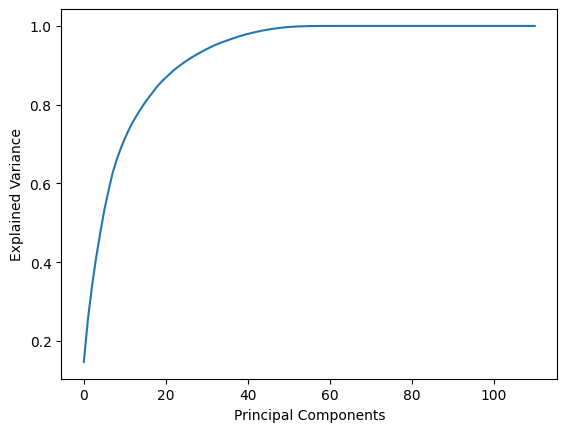

In [1164]:
plt.figure()
plt.plot(np.cumsum(variance_ratio)) # plot cumulative variance ratio over number of principal components
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance")
plt.show()

# Large scale Granger Causality

In [1219]:
def large_scale_gci(df):
    _, rois = df.shape
    X = df.to_numpy()  #
    Xn = normalize(X)  # normalize X
    cov = np.cov(Xn, rowvar=False)  # construct covariance matrix of features, state that feature data is not in row
    eigval, eigvec = eigh(cov)  # eigenvalue decomposition, eval(eigenvalues), eigvec(eigenvectors) is a matrix of
    # eigen vectors
    idx = eigval.argsort()[::-1]  # get indices of sorted eigenvalues and reverse list to get descending order
    eigval = eigval[idx]  # eigen values sorted in descending order
    W = eigvec[:, idx]  # eigen vectors sorted with respect to eigenvalues giving projection matrix W
    W_c = W[:, :35]  # choose the first 35 eigen vectors
    Z = np.dot(Xn, W_c)  # project data on to 35 dimensional space

    mvar = VAR(Z)
    results = mvar.fit(2)  # fit model with maxlag of 2

    z = results.fittedvalues  # model predictions has only 194 rows due to the lag of 2, I will add first two rows from X_ld
    z_hat = np.concatenate((Z[:2, :], z), axis=0)  # concatenate first two rows of X_ld to z
    W_plus = pinv(W_c)  # get pseudo inverse of projection matrix
    E_hat = Xn - np.dot(z_hat, W_plus)

    lsGCI = np.zeros((rois, rois))
    for i in range(rois):
        lsGCI[i, i] = 0
        X_iMinus = np.delete(Xn, i, 1)  # remove ith column from X remove feature from HD space
        W_iMinus = np.delete(W_c, i, 0)  # Remove ith row from projection matrix W
        Z_minus = np.dot(X_iMinus, W_iMinus)  # project matrix without column i onto 35d space
        mvar_minus = VAR(Z_minus)  # initialise new model with Z_minus
        results = mvar_minus.fit(2)  # fit model with maxlag of 2
        z_minus_pred = results.fittedvalues  # model predictions has only 194 rows due to the lag of 2, I will add first two rows from Z_minus
        z_m_hat = np.concatenate((Z_minus[:2, :], z_minus_pred), axis=0)  # concatenate first two rows of X_ld to z

        W_m_plus = pinv(W_iMinus)  # get pseudo inverse of W_iMinus
        E_m = X_iMinus - np.dot(z_m_hat, W_m_plus)  # get error matrix of predictions without ith feature
        E_minus = np.insert(E_m, i, 0, axis=1)  # add a dummy column at removed column

        for j in range(rois):
            if j != i:
                GCI = np.log(np.var(E_minus[:, j]) / np.var(E_hat[:, j]))

                lsGCI[j, i] = max(GCI,0)  # from i to j
            else:
                continue

    return lsGCI

In [1220]:
funtime = large_scale_gci(t1)

In [1221]:
pd.DataFrame(funtime)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.004998,0.000558,0.000000,0.001042,0.000000,...,0.000000,0.000000,0.003041,0.000000,0.000000,0.000000,0.002448,0.000000,0.009643,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.008213,0.005238,0.001209,0.000000,0.000000,0.004883,...,0.000000,0.005179,0.000000,0.000000,0.000352,0.015083,0.000763,0.000000,0.000000,0.010093
2,0.000000,0.000000,0.000000,0.000000,0.000168,0.000000,0.000000,0.000000,0.001154,0.000000,...,0.000000,0.013022,0.000000,0.000000,0.000000,0.000000,0.005920,0.000000,0.011029,0.001777
3,0.000000,0.000000,0.000000,0.000000,0.002825,0.001287,0.000000,0.034142,0.000000,0.001512,...,0.004174,0.018082,0.000000,0.000000,0.000000,0.000000,0.000196,0.010231,0.025594,0.000000
4,0.000000,0.023329,0.000000,0.005358,0.000000,0.008558,0.004374,0.003736,0.001040,0.000000,...,0.000000,0.000000,0.000000,0.026112,0.000000,0.008833,0.000453,0.000000,0.023359,0.001992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.002148,0.007620,0.000000,0.000000,0.001582,0.000948,0.003288,0.000000,0.010346,0.003487,...,0.005193,0.007828,0.000000,0.000000,0.000000,0.000000,0.003852,0.000277,0.000000,0.000000
196,0.002802,0.002928,0.000000,0.000430,0.002090,0.000000,0.004798,0.009019,0.003503,0.000000,...,0.003822,0.005764,0.011607,0.010799,0.002834,0.007414,0.000000,0.002038,0.000000,0.018050
197,0.000000,0.000000,0.000000,0.019219,0.000000,0.000000,0.000000,0.000000,0.000339,0.000000,...,0.000000,0.000547,0.000000,0.000000,0.002703,0.000000,0.000904,0.000000,0.000000,0.000826
198,0.003736,0.000000,0.013885,0.016692,0.007020,0.000000,0.000000,0.000000,0.000000,0.003962,...,0.004432,0.001457,0.001467,0.055759,0.012954,0.000000,0.003530,0.000000,0.000000,0.003743


In [1222]:
max(GCI,0)

0.0028825384869645312

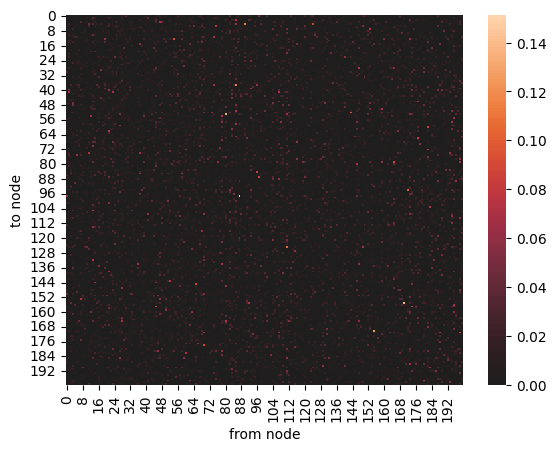

In [1225]:
plt.Figure(figsize=(20,20))
sns.heatmap(funtime, center=0)
plt.xlabel('from node')
plt.ylabel('to node')
plt.show()

In [1107]:
aal_dir = os.path.join(os.getcwd(),'rois_aal')
pheno_path = os.path.join(os.getcwd(), 'phenotype_files','pheno_nn.csv')

In [1108]:
subjects = pheno_df.FILE_ID

In [1109]:
aal_files = [i + '_rois_aal.1D' for i in subjects]

In [1110]:
aal_files

['Pitt_0050002_rois_aal.1D',
 'Pitt_0050003_rois_aal.1D',
 'Pitt_0050004_rois_aal.1D',
 'Pitt_0050005_rois_aal.1D',
 'Pitt_0050006_rois_aal.1D',
 'Pitt_0050007_rois_aal.1D',
 'Pitt_0050008_rois_aal.1D',
 'Pitt_0050009_rois_aal.1D',
 'Pitt_0050010_rois_aal.1D',
 'Pitt_0050011_rois_aal.1D',
 'Pitt_0050012_rois_aal.1D',
 'Pitt_0050013_rois_aal.1D',
 'Pitt_0050014_rois_aal.1D',
 'Pitt_0050015_rois_aal.1D',
 'Pitt_0050016_rois_aal.1D',
 'Pitt_0050017_rois_aal.1D',
 'Pitt_0050019_rois_aal.1D',
 'Pitt_0050020_rois_aal.1D',
 'Pitt_0050022_rois_aal.1D',
 'Pitt_0050023_rois_aal.1D',
 'Pitt_0050024_rois_aal.1D',
 'Pitt_0050025_rois_aal.1D',
 'Pitt_0050026_rois_aal.1D',
 'Pitt_0050027_rois_aal.1D',
 'Pitt_0050028_rois_aal.1D',
 'Pitt_0050029_rois_aal.1D',
 'Pitt_0050030_rois_aal.1D',
 'Pitt_0050031_rois_aal.1D',
 'Pitt_0050032_rois_aal.1D',
 'Pitt_0050033_rois_aal.1D',
 'Pitt_0050034_rois_aal.1D',
 'Pitt_0050035_rois_aal.1D',
 'Pitt_0050036_rois_aal.1D',
 'Pitt_0050037_rois_aal.1D',
 'Pitt_0050038

In [1113]:
aal_fetch = FetchROI(aal_dir)

In [1212]:
aal1 = aal_fetch.fetch_roi_avg_ts(aal_files[0])

In [1213]:
funtime1 = large_scale_gci(aal1)

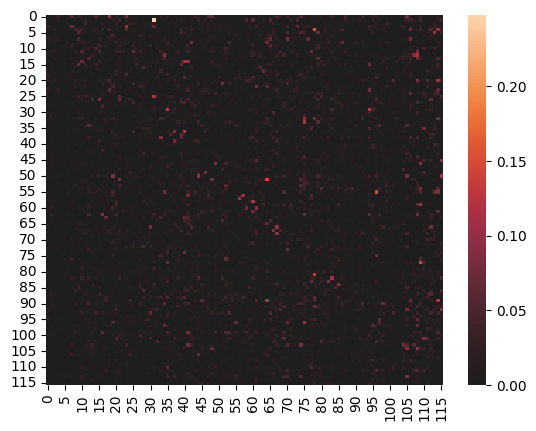

In [1214]:
plt.Figure(figsize=(20,20))
sns.heatmap(funtime1, center=0)
plt.show()

In [1235]:
 cc200df = pheno_df.loc[:,['FILE_ID', 'DSM_IV_TR', 'DX_GROUP']]

In [1283]:
cc200df.DSM_IV_TR.unique()

array([    1,     0,     2, -9999,     3,     4])

In [1282]:
asd = cc200df[cc200df['DX_GROUP'] == 1].FILE_ID
control = cc200df[cc200df['DX_GROUP'] == 2].FILE_ID

In [1245]:
asd_files = [a + '_gci.pkl' for a in asd]
control_files = [c + '_gci.pkl' for c in control]

In [1247]:
gci_cc200_dir = os.path.join(os.getcwd(), 'gci_cc200')

In [1248]:
picker = PickPickle(gci_cc200_dir)

In [1284]:
os.path.join(gci_cc200_dir, 'asd_mean.pkl')

'/Users/admin/Documents/MscProject/gci_cc200/asd_mean.pkl'

In [1251]:
m1 = picker.get_pickle(asd_files[0])

In [1285]:
m2 = picker.get_pickle('/Users/admin/Documents/MscProject/gci_cc200/asd_mean.pkl')

TypeError: only integer scalar arrays can be converted to a scalar index

In [1258]:
a1 = np.mean( np.array([ m1, m2 ]), axis=0 )

In [1259]:
a1

array([[0.        , 0.        , 0.        , ..., 0.        , 0.00357274,
        0.01052549],
       [0.        , 0.        , 0.00536241, ..., 0.00614809, 0.        ,
        0.01334805],
       [0.00493512, 0.00109347, 0.        , ..., 0.00137124, 0.00909726,
        0.        ],
       ...,
       [0.00192688, 0.00528741, 0.00077125, ..., 0.        , 0.01781986,
        0.        ],
       [0.00510853, 0.        , 0.00551437, ..., 0.03782583, 0.        ,
        0.02214748],
       [0.00847207, 0.01949368, 0.00088853, ..., 0.00045899, 0.01785929,
        0.        ]])

In [1261]:
go = [picker.get_pickle(asd_files[i]) for i in range(2)]

In [1271]:
d = np.array(go)

In [1272]:
a1 = np.mean( d, axis=0 )

In [1322]:
asd = picker.get_pickle("Caltech_0051459_gci.pkl")
control = picker.get_pickle('control_mean.pkl')

In [1324]:
asd

array([[0.        , 0.        , 0.        , ..., 0.00042433, 0.        ,
        0.00011094],
       [0.        , 0.        , 0.00185421, ..., 0.        , 0.03387672,
        0.00410043],
       [0.00516988, 0.        , 0.        , ..., 0.        , 0.00391857,
        0.02019601],
       ...,
       [0.00016253, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00442866, 0.        , ..., 0.        , 0.        ,
        0.01288637],
       [0.        , 0.01258792, 0.        , ..., 0.        , 0.        ,
        0.        ]])

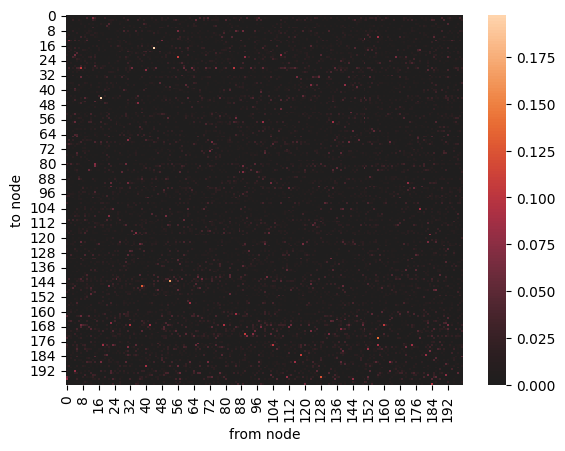

In [1323]:

plt.Figure(figsize=(20,20))
sns.heatmap(asd, center=0)
plt.xlabel('from node')
plt.ylabel('to node')
plt.show()

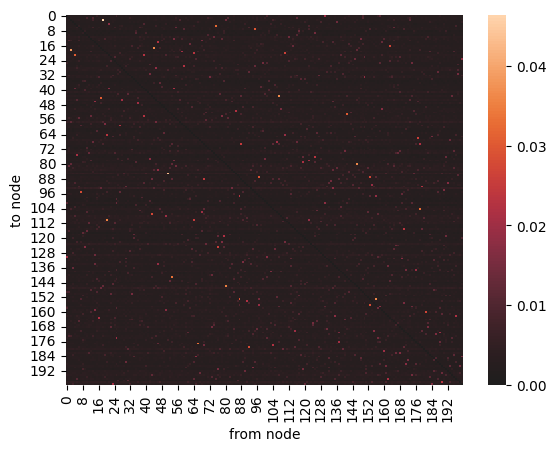

In [1294]:
plt.Figure(figsize=(20,20))
sns.heatmap(control, center=0)
plt.xlabel('from node')
plt.ylabel('to node')
plt.show()

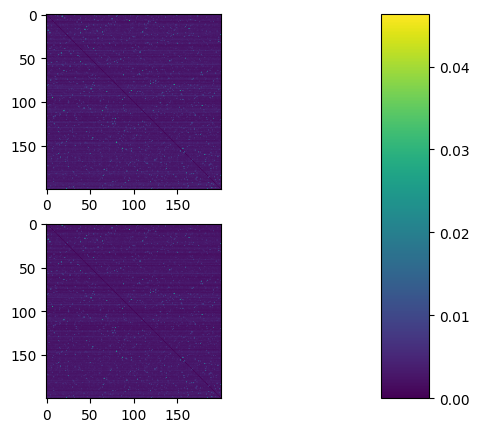

In [1291]:

plt.subplot(211)
plt.imshow(asd)
plt.subplot(212)
plt.imshow(control)

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)

plt.show()

In [1295]:
aal_dir = os.path.join(os.getcwd(), 'gci_aal')
AALpicker = PickPickle(aal_dir)

In [1327]:
asd

array([[0.        , 0.        , 0.00123416, ..., 0.00096875, 0.00308704,
        0.00187442],
       [0.        , 0.        , 0.00533994, ..., 0.00073944, 0.00536204,
        0.00100761],
       [0.00112092, 0.00297326, 0.        , ..., 0.00419181, 0.00029289,
        0.        ],
       ...,
       [0.        , 0.01270255, 0.01640296, ..., 0.        , 0.        ,
        0.        ],
       [0.04448542, 0.        , 0.        , ..., 0.        , 0.        ,
        0.03543392],
       [0.00165577, 0.02148733, 0.        , ..., 0.        , 0.        ,
        0.        ]])

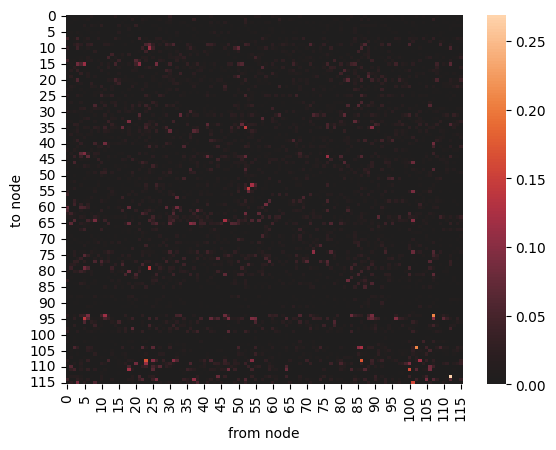

In [1326]:
asd = AALpicker.get_pickle('Caltech_0051456_gci_aal.pkl')
control = AALpicker.get_pickle('control_mean.pkl')

plt.Figure(figsize=(20, 20))
sns.heatmap(asd, center=0)
plt.xlabel('from node')
plt.ylabel('to node')
plt.show()

In [ ]:
plt.Figure(figsize=(20, 20))
sns.heatmap(control, center=0)
plt.xlabel('from node')
plt.ylabel('to node')
plt.show()

In [1319]:
def large_scale_gci(df):
    _, rois = df.shape
    Z = df.to_numpy()
    Z = normalize(Z)

    mvar = VAR(Z)
    results = mvar.fit(2)  # fit model with maxlag of 2

    E_hat = results.resid

    lsGCI = np.zeros((rois, rois))
    for i in range(rois):
        lsGCI[i, i] = 0
        X_iMinus = np.delete(Xn, i, 1)  # remove ith column from X remove feature from HD space
        mvar_minus = VAR(X_iMinus)  # initialise new model with Z_minus
        results_minus = mvar_minus.fit(2)

        E_minus = results_minus.resid
        E_minus = np.insert(E_minus, i, 0, axis=1)  # add a dummy column at removed column

        for j in range(rois):
            if j != i:
                GCI = np.log(np.var(E_minus[:, j]) / np.var(E_hat[:, j]))

                lsGCI[j, i] = max(GCI, 0)  # from i to j
            else:
                continue

    return lsGCI

In [1315]:
 mvar = VAR(t1.to_numpy())
results = mvar.fit(2)  # fit model with maxlag of 2

In [1316]:
results.resid.shape

(194, 200)

In [1320]:
y = large_scale_gci(t1)

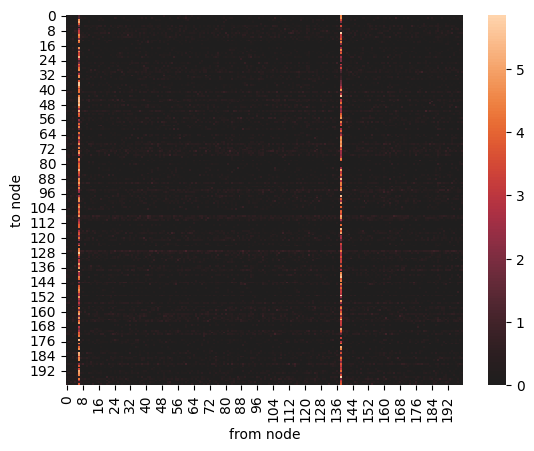

In [1321]:
plt.Figure(figsize=(20, 20))
sns.heatmap(y, center=0)
plt.xlabel('from node')
plt.ylabel('to node')
plt.show()

In [1328]:
[print(i) for i in range(5)]

0
1
2
3
4


[None, None, None, None, None]

## traditional granger

In [10]:
t1

,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10,...,#191,#192,#193,#194,#195,#196,#197,#198,#199,#200\r
0,1.246156,-4.307913,10.584696,-3.748496,4.160355,15.479354,-5.334384,7.725643,-8.526148,-5.099441,...,-6.055043,-3.895240,-1.204225,-25.303493,-7.036281,-1.353554,7.662059,-1.384268,-2.921266,-0.229492
1,-15.982376,5.064672,17.719229,3.456765,7.125198,11.360184,4.379779,-2.329262,-14.282903,-12.342685,...,-0.026510,-9.528214,3.259091,-19.429215,-9.264935,-16.439756,5.460418,3.486045,-9.058471,-13.512323
2,-33.027058,18.449268,20.540874,13.550962,9.294488,-2.100499,12.165511,-15.178822,-15.598850,-16.641183,...,9.881498,-17.619938,9.341403,-4.424534,-15.399741,-27.362760,-1.842440,11.183846,-10.137650,-23.538741
3,-42.463522,29.374632,16.764322,19.622914,8.582539,-18.578201,14.853411,-23.060956,-10.067372,-14.431966,...,18.909646,-23.778837,11.896599,12.224762,-26.262796,-25.569006,-12.159674,19.515875,-4.440521,-24.576479
4,-40.872033,31.067612,7.041686,15.895454,3.386940,-28.699576,14.514831,-20.102640,1.173444,-5.214644,...,22.037617,-22.424810,6.845053,22.248913,-37.526504,-9.846139,-20.503810,25.114531,4.942190,-16.661969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,-10.208673,-22.918221,-19.164334,17.070753,-2.373314,25.887166,-0.103792,1.986457,-3.881973,3.411133,...,1.963963,1.908752,7.149181,-11.529298,-1.023148,11.204552,8.303065,-6.277609,-10.298093,10.388477
192,1.262442,-25.040055,-14.544518,15.250407,-1.371992,26.209950,-7.875112,3.743777,-1.024422,5.304909,...,-1.669239,3.515944,2.048182,-4.800618,7.615401,-2.848081,32.384099,-2.107759,3.747349,10.584493
193,16.483690,-12.257749,2.495898,6.610912,2.838234,14.833370,-13.852379,3.012064,1.736094,2.706269,...,-5.440964,3.410611,0.729046,0.820211,18.218859,-19.644533,44.051967,1.352303,12.582224,8.264416
194,29.318936,6.021157,20.246783,-3.603822,6.699642,-0.643308,-13.805983,-0.372582,3.767681,-1.745966,...,-7.954049,3.726422,1.205458,4.802952,26.605181,-32.151762,41.244052,2.013143,13.091565,1.757288


In [33]:
def gci(df):
    _, rois = df.shape
    X = df.to_numpy()  #
    Xn = normalize(X)  # normalize X


    mvar = VAR(Xn)
    results = mvar.fit(2)  # fit model with maxlag of 2

    E_hat = results.resid

    GCI = np.zeros((rois, rois))
    for i in range(rois):
        GCI[i, i] = 1

        X_iMinus = np.delete(Xn, i, 1)  # remove ith column from X remove feature from HD space
        mvar_minus = VAR(X_iMinus)  # initialise new model with Z_minus
        results_minus = mvar_minus.fit(2)  # fit model with maxlag of 2

        E_m = results_minus.resid  # get error matrix of predictions without ith feature
        E_minus = np.insert(E_m, i, 0, axis=1)  # add a dummy column at removed column

        for j in range(rois):
            if j != i:
                gci = np.log(np.var(E_minus[:, j]) / np.var(E_hat[:, j]))

                GCI[j, i] = max(gci,0)  # from i to j
            else:
                continue

    return GCI

In [34]:
gci(t1)

array([[1.        , 0.23282658, 0.31000074, ..., 0.        , 0.08194216,
        0.14105961],
       [0.        , 1.        , 0.19550863, ..., 0.02619156, 0.20676646,
        0.        ],
       [0.16895457, 0.45459443, 1.        , ..., 0.        , 0.41268222,
        0.16441264],
       ...,
       [0.61952317, 0.02916605, 0.11028706, ..., 1.        , 0.36389649,
        0.30921903],
       [0.33498978, 0.3279613 , 0.32653336, ..., 0.03950069, 1.        ,
        0.        ],
       [0.02250843, 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [11]:
X = t1.to_numpy()  #
Xn = normalize(X)  # normalize X
mvar = VAR(Xn)

In [13]:
results = mvar.fit(2)

In [15]:
results.fittedvalues

array([[-1.65973226e-01,  9.27144201e-02,  1.03225516e-01, ...,
         5.62029776e-02, -5.09454543e-02, -1.18290911e-01],
       [-1.70163782e-01,  1.17712762e-01,  6.71795532e-02, ...,
         7.82058328e-02, -1.77944695e-02, -9.84851566e-02],
       [-1.50981095e-01,  1.14763611e-01,  2.60119545e-02, ...,
         9.27729578e-02,  1.82564264e-02, -6.15492339e-02],
       ...,
       [ 7.95787457e-02, -5.91770586e-02,  1.20495125e-02, ...,
         6.52854900e-03,  6.07435354e-02,  3.98983396e-02],
       [ 1.16377722e-01,  2.39002035e-02,  8.03669845e-02, ...,
         7.99091060e-03,  5.19652728e-02,  6.97532726e-03],
       [ 1.35448680e-01,  7.72269952e-02,  1.13539590e-01, ...,
         8.88604694e-05,  3.00091797e-02, -3.12012928e-02]])

In [22]:
E_hat = results.resid

In [30]:
del i

NameError: name 'i' is not defined

In [20]:
i = 2
X_iMinus = np.delete(Xn, i, 1)  # remove ith column from X remove feature from HD space
mvar_minus = VAR(X_iMinus)  # initialise new model with Z_minus
results_minus = mvar_minus.fit(2)  # fit model with maxlag of 2
E_m = results_minus.resid  # get error matrix of predictions without ith feature
E_minus = np.insert(E_m, i, 0, axis=1)

In [21]:
E_minus

array([[ 1.29454530e-10, -3.92493676e-11,  0.00000000e+00, ...,
         1.63131730e-11,  7.65888325e-11, -9.55532875e-11],
       [-4.35816938e-11, -2.80451634e-11,  0.00000000e+00, ...,
        -1.14058624e-11, -5.02664924e-12, -1.21032448e-10],
       [ 1.69360082e-11, -6.59653443e-11,  0.00000000e+00, ...,
         7.73580505e-11, -3.26348323e-12,  5.53318710e-11],
       ...,
       [-4.25211116e-11, -2.73354957e-10,  0.00000000e+00, ...,
         2.32697455e-12,  3.51580570e-11,  4.85210969e-11],
       [-2.78374546e-11, -1.43519276e-10,  0.00000000e+00, ...,
         4.13218453e-11,  9.21006951e-11, -9.41380090e-11],
       [ 1.77363735e-10, -3.58078012e-11,  0.00000000e+00, ...,
         1.24553648e-10,  1.83895829e-10, -1.74244286e-10]])

In [23]:
GCI = np.log(np.var(E_minus[:, 1]) / np.var(E_hat[:, 1]))

In [24]:
GCI

0.19550862938865476

In [46]:
gci_1=np.load('/Users/admin/Documents/MscProject/gci_nls_cc200/Leuven_2_0050723_gci.npy')

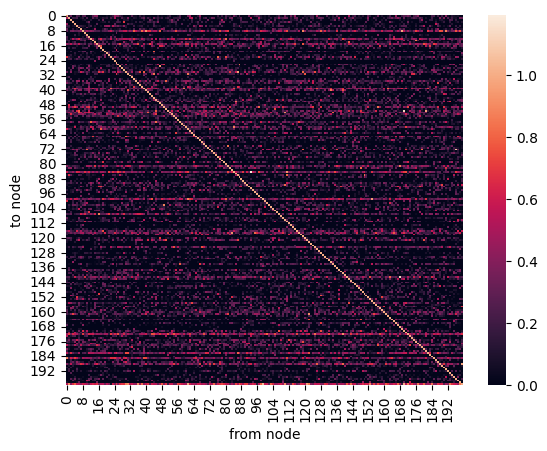

In [47]:
plt.Figure(figsize=(20, 20))
sns.heatmap(gci_1)
plt.xlabel('from node')
plt.ylabel('to node')
plt.show()